In [1]:
import os
import pathlib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gemmi
import seaborn as sns

## Goal    
distribution of water occupacy

In [2]:
# Training set.
train_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/train_split.txt", header=None)
train_list = train_list[0].tolist()
# Test set.
test_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/test_split.txt", header=None)
test_list = test_list[0].tolist()

In [3]:
## Collect water residues.
## Loop through all pdb files.
pdb_path = pathlib.Path('/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data')
pdbs = list(pdb_path.glob('*_final.pdb')) # Pay attention to the pattern of names. A general "*.pdb" would result in duplicate files when looping.
# Train.
pdb_train = []
for a in pdbs:
    name = a.stem.split('_')[0]
    if name in train_list:
        pdb_train.append(a)
# Test.
pdb_test = []
for a in pdbs:
    name = a.stem.split('_')[0]
    if name in test_list:
        pdb_test.append(a)

In [4]:
# Create a dictionary of chains and the list of mols of interest for BOTH training and test sets.
data1, data2 = pdb_train, pdb_test
filter = ['HOH', 'WAT', 'H2O'] # List of crystallographic ligands.

keys=['name', 'structure']
chain_keys=['seq_id', 'res', 'b_fac', 'occ']
wat_train_dict, wat_test_dict = {k: [] for k in keys}, {k: [] for k in keys}
for all_dict, data in zip([wat_train_dict, wat_test_dict], [data1, data2]):
    for a in data: # Loop over all PDB structures.
        name = a.stem.split('_')[0]
        structure = gemmi.read_structure(str(a))
        # Check model.
        i = 0
        model = structure[i]  # consider the first model (skip if empty)
        while len(model) == 0:  # sometimes the first model is empty
            i += 1
            try:
                model = structure[i]
            except Exception:
                raise ValueError("Can't read valid model from the input PDB file!")
        # Chain.
        chain_dict={}
        for chain in model:
            ind_chain={k: [] for k in chain_keys} # seq_id, res, b_fac
            res_list=[]
            id_list=[]
            b_fac=[]
            occ=[]
            for res in chain:
                if res.name in filter: # Check if it is not in any of the filter lists.
                    res_list.append(res.name)
                    id_list.append(int(res.seqid))
                    b_fac.append(res[0].b_iso) # Only one atom in water residue: O atom.
                    occ.append(res[0].occ)
            ind_chain['seq_id']=id_list
            ind_chain['res']=res_list
            ind_chain['b_fac']=b_fac
            ind_chain['occ']=occ
            # For each chain.
            chain_dict[chain.name] = ind_chain
        # Summarize as {chain: list of mols of interest}.
        all_dict['name'].append(name)
        all_dict['structure'].append(chain_dict)

In [16]:
def nested_wat_value(structure_dict, key='occ'):
    """
    Return all values of interest stored in the chain dictionary. For example, when key is 'occ', returns the list of all occupancy values of water.
    """
    pdb_value = []
    for k, v in structure_dict.items(): # k is the chain name. v is the individual chain dictionary, with keys: seq_id, res, b_fac, occ.
        value = v[key]
        pdb_value.append(value)
    return pdb_value

In [9]:
df_wat_train = pd.DataFrame(wat_train_dict)   
df_wat_test = pd.DataFrame(wat_test_dict)

# Apply the function to each row of the dataframe.
for df in [df_wat_train, df_wat_test]:
    df['occ'] = None
    df['occ'] = df['structure'].apply(nested_wat_value)

In [10]:
df_wat_test

,name,structure,occ
0,6zw2,"{'A': {'seq_id': [501, 502, 503, 504, 505, 506...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0,..."
1,4hr3,"{'A': {'seq_id': [601, 602, 603, 604, 605, 606...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,6yp2,"{'A': {'seq_id': [401, 402, 403, 404, 405, 406...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,5pbi,"{'A': {'seq_id': [2102, 2103, 2105, 2106, 2107...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,7f5c,"{'A': {'seq_id': [301, 304, 305, 307, 308, 309...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
...,...,...,...
1288,3vha,"{'A': {'seq_id': [2, 3, 4, 5, 6, 7, 238, 239, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1289,4xua,"{'A': {'seq_id': [2101, 2103, 2104, 2105, 2106...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1290,7o5s,"{'A': {'seq_id': [401, 403, 404, 405, 406, 407...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1291,6agy,"{'A': {'seq_id': [201, 202, 203, 204, 205, 206...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


1489982


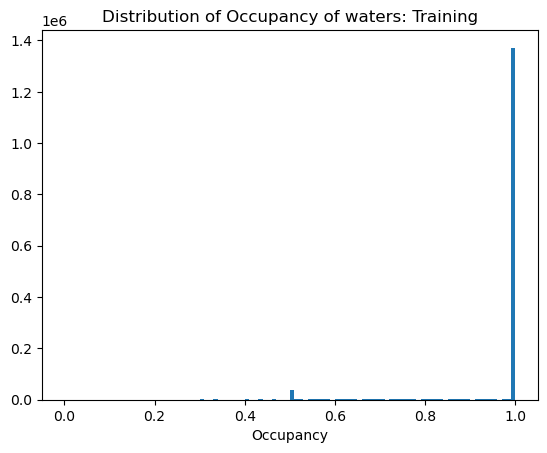

In [11]:
# Plot. Training set.
nested = df_wat_train['occ'].values
flat=[water for structure in nested for chain in structure for water in chain]
print(len(flat))
plt.hist(flat, bins=100)
plt.xlabel("Occupancy")
# plt.ylabel("Number of molecules")
plt.title("Distribution of Occupancy of waters: Training")
plt.savefig("figures/6_water_occ_train.png", dpi=200)
plt.show()

412396


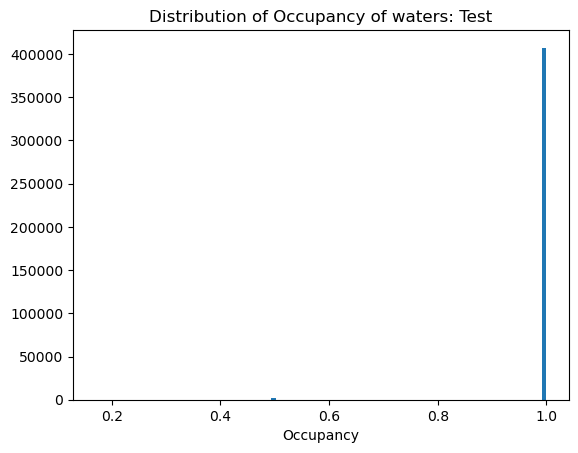

In [12]:
# Plot. Test set.
nested = df_wat_test['occ'].values
flat=[water for structure in nested for chain in structure for water in chain]
print(len(flat))
plt.hist(flat, bins=100)
plt.xlabel("Occupancy")
# plt.ylabel("Number of molecules")
plt.title("Distribution of Occupancy of waters: Test")
plt.savefig("figures/6_water_occ_test.png", dpi=200)
plt.show()

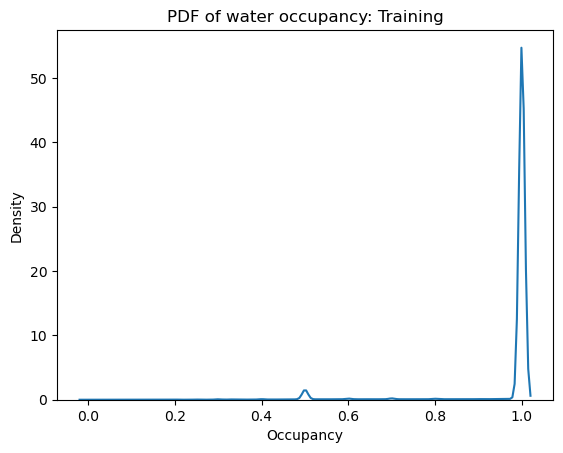

In [13]:
# PDF plot.
nested = df_wat_train['occ'].values
flat=[water for structure in nested for chain in structure for water in chain]
df = pd.DataFrame(flat, columns=['Occupancy'])
sns.kdeplot(df, x='Occupancy')
# sns.histplot(df, x='Number of residues')
# plt.xlabel("Number of residues")
# plt.ylabel("Number of chains")
plt.title("PDF of water occupancy: Training")
plt.savefig("figures/6_PDF_water_train.png", dpi=200)
plt.show()

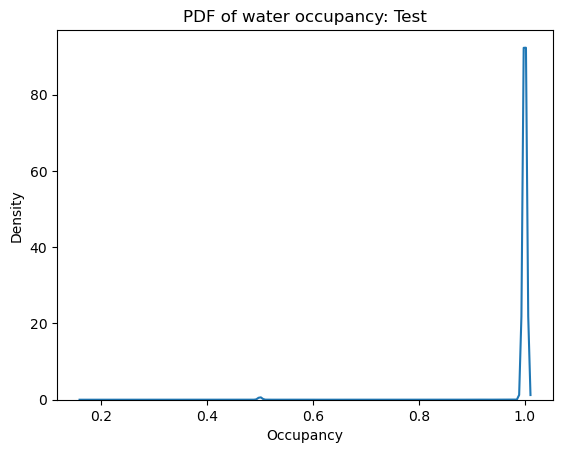

In [14]:
# PDF plot.
nested = df_wat_test['occ'].values
flat=[water for structure in nested for chain in structure for water in chain]
df = pd.DataFrame(flat, columns=['Occupancy'])
sns.kdeplot(df, x='Occupancy')
# sns.histplot(df, x='Number of residues')
# plt.xlabel("Number of residues")
# plt.ylabel("Number of chains")
plt.title("PDF of water occupancy: Test")
plt.savefig("figures/6_PDF_water_test.png", dpi=200)
plt.show()

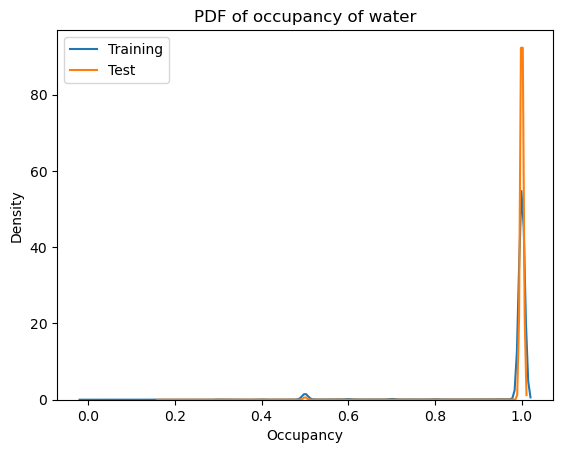

In [15]:
# Plots. 
x_label = 'Occupancy'
nested = df_wat_train['occ'].values
flat=[water for structure in nested for chain in structure for water in chain]
nested2 = df_wat_test['occ'].values
flat2=[water for structure in nested2 for chain in structure for water in chain]
df = pd.DataFrame(flat, columns=[x_label])
df2 = pd.DataFrame(flat2, columns=[x_label])
sns.kdeplot(df, x=x_label, label='Training')
sns.kdeplot(df2, x=x_label, label='Test')
plt.title("PDF of occupancy of water")
plt.legend()
plt.savefig("figures/6_PDF_Both_water_occ.png", dpi=200)
plt.show()